# Optimise on a single quad scan

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [8]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[1]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

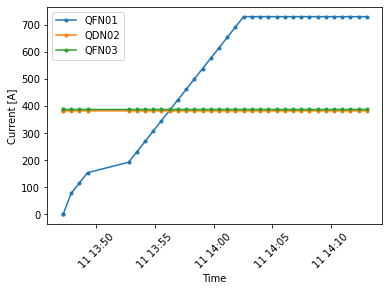

In [9]:
timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots()

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax.plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax.plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax.plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax.tick_params('x', labelrotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Current [A]")
ax.legend()

Text(0.5, 1.0, 'Beam size')

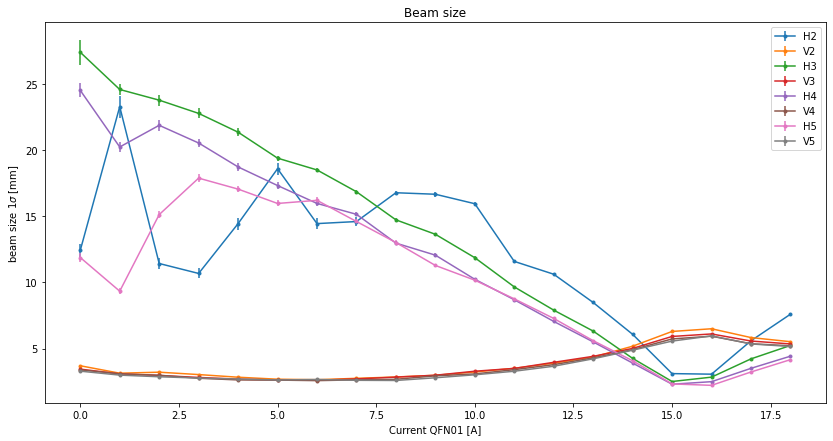

In [35]:
fig, ax = plt.subplots(figsize=(14,7))

range_shots = [1,len(acquisition)-15]
x_axis = np.linspace(0,18,len(acquisition)-16)

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")
ax.legend()
ax.set_xlabel("Current QFN01 [A]")
ax.set_ylabel(f"beam size 1$\sigma$ [mm]")
ax.set_title("Beam size")

In [37]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [38]:
# Initial conditions East Area
betx0 = 81.278
bety0 = 3.024
alfx0 = -19.03
alfy0 = 1.889
Dx0 = -7.708
Dy0 = -1.981
Dpx0 = -1.938
Dpy0 = -0.01
exn = 1.463e-06
eyn = 1.499e-06
sige = 0.000761115

In [39]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []

current1 = qfn01_current[range_shots[0]:range_shots[1]:]
current2 = qdn02_current[range_shots[0]:range_shots[1]:]
current3 = qfn03_current[range_shots[0]:range_shots[1]:]

for i in range(len(current1)):
    quad_current["QFN01"] = current1[i]
    quad_current["QDN02"] = current2[i]
    quad_current["QFN03"] = current3[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")
    
    madx.use(sequence="f61d")
    # Initial settings
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0.5, 1.0, 'Multi Quad Scan BTV010')

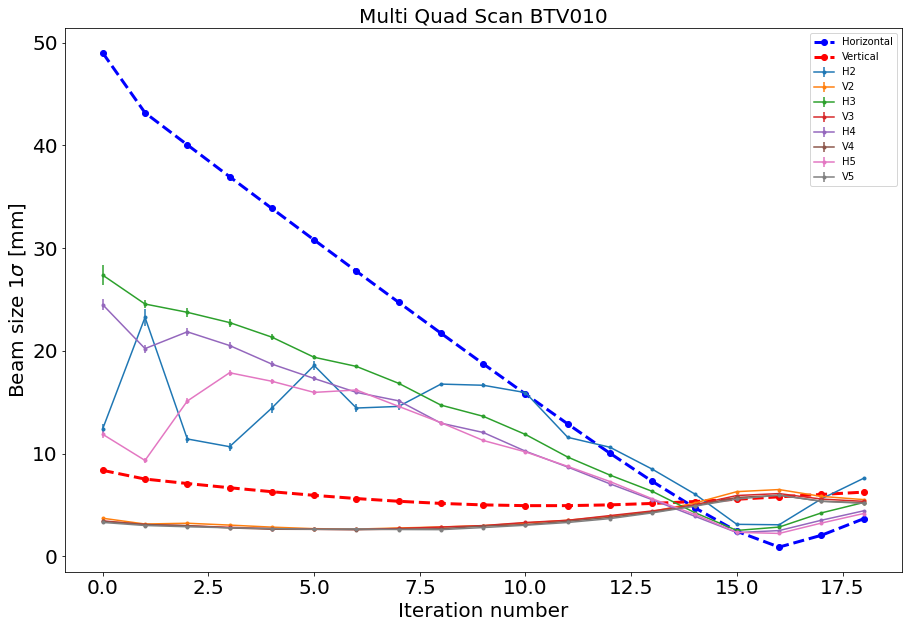

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

H_sigma_list = []
V_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")

    H_sigma_list.append(H_sigma_list_i)
    V_sigma_list.append(V_sigma_list_i)
    
ax.plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "Horizontal")
ax.plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "Vertical")


ax.legend()
ax.set_xlabel("Iteration number", fontsize=20)
ax.set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.savefig("fig/madx_"+str(filename)+".png", facecolor='white', transparent=False,
                    bbox_inches='tight', dpi=150);
ax.set_title("Multi Quad Scan BTV010", fontsize = 20)

# Optimize with different starting parameter

In [46]:
# Py-BOBYQA example: minimize the Rosenbrock function
from __future__ import print_function
import pybobyqa

exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


# Define the objective function
def f_fit(params):
    print(params)
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params

    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)
    

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

    madx.input('SEQEDIT, SEQUENCE=f61d;')
    madx.input('FLATTEN;')
    madx.input('REMOVE, ELEMENT=ARBMATRIX;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    
    
    H_sigma_madx = []
    V_sigma_madx = []

    current1 = qfn01_current[range_shots[0]:range_shots[1]:]
    current2 = qdn02_current[range_shots[0]:range_shots[1]:]
    current3 = qfn03_current[range_shots[0]:range_shots[1]:]

    for i in range(len(current1)):
        quad_current["QFN01"] = current1[i]
        quad_current["QDN02"] = current2[i]
        quad_current["QFN03"] = current3[i]

        madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
        V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

    deltaH = abs(H_sigma_list[2][range_shots[0]:range_shots[1]:] - np.array(H_sigma_madx)*1000)**2 # Here you have to choose with acquisition to optimise. I choose acq 4
    deltaV = abs(V_sigma_list[2][range_shots[0]:range_shots[1]:] - np.array(V_sigma_madx)*1000)**2
    
    objective = sum(deltaH) + sum(deltaV)
        
    print (objective)
    return (objective)

# Define the starting point
# initial_guess = [82.4, 33.2, -11.1, 0.28, 0.13, 0.0, 0.02, 0.0, 1.5e-6, 1.5e-6, 7.53e-4]
initial_guess = [8.10320374e+01, 1.75850966e+00, -1.24235188e+01, 1.38448554e+00, -4.89293824e+00, -9.90627329e-01, -1.26489793e+00, -3.91133201e-02, 1.49710514e-06, 1.48850811e-06, 7.50894919e-04]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0])
upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])


# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-8)

# Display output
print(soln)

[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
270.0566713915961
[ 1.50000000e+02  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
417.4520846790966
[ 8.10320374e+01  7.62585097e+01 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
306.9624138989968
[ 8.10320374e+01  1.75850966e+00  8.75764812e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
29708.96513592267
[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.00000000e+02
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
1678437.0163579418
[ 8.10320

3118.2404931671713
[ 8.31632986e+01  4.60055504e+00 -1.03599724e+01 -2.31335412e+00
 -5.23037423e+00 -8.92584241e-01 -2.10290857e-02  3.78851952e-01
  3.93992504e-08  1.61281619e-06  7.75145206e-04]
3149.398853835378
[ 8.01876568e+01  8.30937305e+00 -1.10732700e+01 -1.66297254e+00
 -4.30806100e+00  6.77723557e-01 -7.48383847e-01 -9.99589220e+00
  0.00000000e+00  1.44136506e-06  7.64215022e-04]
286649.9229438816
[ 8.14311939e+01  4.68040844e+00 -1.04317912e+01 -3.48342001e+00
 -4.19073781e+00 -1.03599737e+00  1.35676883e-01  4.29227426e-01
  0.00000000e+00  1.25227970e-06  8.01871693e-04]
3670.892573767367
[ 8.01863955e+01  8.43139801e+00 -1.11170296e+01 -1.52621744e+00
 -1.43383044e+01  6.78096775e-01 -6.83696131e-01 -1.62233546e-02
  0.00000000e+00  1.43330360e-06  7.68124330e-04]
8104.170869922848
[ 8.41848431e+01  7.90922784e+00 -1.87599057e+01 -1.41893751e+00
 -3.75117288e+00 -6.20580537e-01  2.98113674e-02  3.95547411e-01
  0.00000000e+00  1.41772659e-06  7.37110572e-04]
2878.1418

31.833573222509195
[ 8.03983489e+01  8.91586189e+00 -1.20586564e+01 -1.24881927e+00
 -3.65014699e+00  3.84306610e-01 -1.10054143e+00  2.17449967e-01
  3.23302041e-09  1.45091476e-06  7.69372290e-04]
32.10233571214631
[ 8.03109426e+01  8.89039747e+00 -1.19505805e+01 -1.27549501e+00
 -3.63553788e+00  3.39804439e-01 -1.08662573e+00  2.39144911e-01
  3.83006681e-09  1.45124476e-06  7.69390097e-04]
33.07745715510806
[ 8.03326272e+01  8.89991864e+00 -1.19976168e+01 -1.25114370e+00
 -3.70858082e+00  2.82037582e-01 -1.10274342e+00  2.22833611e-01
  3.75502196e-09  1.44982409e-06  7.69799241e-04]
32.52065292072271
[ 8.03431269e+01  8.93724570e+00 -1.20300994e+01 -1.27993448e+00
 -3.73642862e+00  3.66476540e-01 -1.09654648e+00  2.11547964e-01
  3.53467056e-09  1.45071431e-06  7.69064285e-04]
35.38508944231581
[ 8.03876110e+01  8.91102626e+00 -1.19722762e+01 -1.22896808e+00
 -3.60941118e+00  3.85194136e-01 -1.10640318e+00  2.16896717e-01
  4.35455636e-09  1.45078359e-06  7.69011893e-04]
31.124378

28.449933510874057
[ 8.03762701e+01  8.96924163e+00 -1.18277723e+01 -1.08528673e+00
 -3.46475143e+00  2.15626316e-01 -1.09267281e+00  2.22882880e-01
  1.13743883e-08  1.45055137e-06  7.68205054e-04]
28.590826584287704
[ 8.03739904e+01  8.95306024e+00 -1.17989093e+01 -1.09460200e+00
 -3.47712179e+00  2.09288892e-01 -1.09147769e+00  2.23351354e-01
  1.11904441e-08  1.45031873e-06  7.68338387e-04]
28.561671197228176
[ 8.03804879e+01  8.96160955e+00 -1.18060783e+01 -1.09753851e+00
 -3.48909282e+00  2.12107404e-01 -1.09368519e+00  2.27523256e-01
  1.12449086e-08  1.44985583e-06  7.68369074e-04]
28.451398074160586
[ 8.03800953e+01  8.95611228e+00 -1.18053290e+01 -1.09527223e+00
 -3.47816397e+00  2.20619681e-01 -1.09843616e+00  2.34352203e-01
  1.13558086e-08  1.45018088e-06  7.68366871e-04]
28.581398291714482
[ 8.03792981e+01  8.95787753e+00 -1.17994176e+01 -1.09340169e+00
 -3.48508597e+00  2.23702648e-01 -1.09354733e+00  2.29046382e-01
  1.12259249e-08  1.45008674e-06  7.68360417e-04]
28.44

28.343520205534993
[ 8.03973858e+01  8.93920766e+00 -1.17150137e+01 -1.07359657e+00
 -3.51118522e+00  2.28917530e-01 -1.09396014e+00  2.32439967e-01
  1.52449231e-08  1.45100561e-06  7.68739186e-04]
28.335005869895205
[ 8.04049896e+01  8.93727722e+00 -1.17051889e+01 -1.05847462e+00
 -3.49752555e+00  2.40288214e-01 -1.09363136e+00  2.33101420e-01
  1.54743137e-08  1.45165902e-06  7.68649646e-04]
28.30048426313208
[ 8.03996254e+01  8.93364767e+00 -1.16934606e+01 -1.05473814e+00
 -3.50389422e+00  2.52483885e-01 -1.09409974e+00  2.35548021e-01
  1.62878804e-08  1.45192031e-06  7.68679887e-04]
28.304230822469602
[ 8.04031450e+01  8.94277696e+00 -1.16988807e+01 -1.06056962e+00
 -3.49372510e+00  2.35220527e-01 -1.08638149e+00  2.44821693e-01
  1.55116229e-08  1.45177100e-06  7.68715107e-04]
28.901135849834173
[ 8.04146129e+01  8.93441167e+00 -1.17105101e+01 -1.05677255e+00
 -3.49895017e+00  2.50645512e-01 -1.09453835e+00  2.30982440e-01
  1.56728346e-08  1.45162605e-06  7.68621846e-04]
28.291

28.27726099554521
[ 8.04135887e+01  8.94079590e+00 -1.17066249e+01 -1.05799718e+00
 -3.50117108e+00  2.40009869e-01 -1.09311757e+00  2.31742931e-01
  1.60223989e-08  1.45154729e-06  7.68606375e-04]
28.286488550898838
[ 8.04118807e+01  8.94077374e+00 -1.17055279e+01 -1.05657645e+00
 -3.50200734e+00  2.41947868e-01 -1.09495165e+00  2.30396382e-01
  1.61814247e-08  1.45164556e-06  7.68620121e-04]
28.2715630668257
[ 8.04113050e+01  8.94196496e+00 -1.17087498e+01 -1.05697051e+00
 -3.50152280e+00  2.44914717e-01 -1.09504990e+00  2.30442384e-01
  1.63195874e-08  1.45168022e-06  7.68590462e-04]
28.268936349709175
[ 8.04019811e+01  8.94191840e+00 -1.17150816e+01 -1.05845763e+00
 -3.50751046e+00  2.56542501e-01 -1.09515163e+00  2.30622566e-01
  1.69228007e-08  1.45188761e-06  7.68573277e-04]
28.26556375328807
[ 8.03987778e+01  8.94820598e+00 -1.17176350e+01 -1.06203790e+00
 -3.50762082e+00  2.61720525e-01 -1.09499995e+00  2.28614192e-01
  1.76235977e-08  1.45198335e-06  7.68481835e-04]
28.271432

27.76371754500259
[ 8.01794132e+01  9.01322220e+00 -1.16878845e+01 -1.01958749e+00
 -3.52782070e+00  2.31816127e-01 -1.09567711e+00  2.32892305e-01
  3.42925402e-08  1.45552458e-06  7.67838521e-04]
27.761770807901897
[ 8.01793835e+01  9.01365957e+00 -1.16880052e+01 -1.01922811e+00
 -3.52759531e+00  2.32244385e-01 -1.09574668e+00  2.32850711e-01
  3.42968930e-08  1.45553567e-06  7.67836465e-04]
27.760269487882955
[ 8.01791515e+01  9.01503973e+00 -1.16883392e+01 -1.01894915e+00
 -3.52739771e+00  2.34521357e-01 -1.09555026e+00  2.32606525e-01
  3.43263951e-08  1.45558875e-06  7.67826179e-04]
27.755960538605507
[ 8.01783321e+01  9.01750635e+00 -1.16962096e+01 -1.01617655e+00
 -3.52501731e+00  2.42857663e-01 -1.09539105e+00  2.31863933e-01
  3.43580446e-08  1.45577311e-06  7.67761004e-04]
27.744336226854692
[ 8.01810866e+01  9.01924191e+00 -1.17041409e+01 -1.01829046e+00
 -3.52166077e+00  2.50035067e-01 -1.09586564e+00  2.32560708e-01
  3.44157624e-08  1.45583209e-06  7.67663463e-04]
27.733

27.68423132886947
[ 8.01708391e+01  9.00498325e+00 -1.16998260e+01 -9.98766986e-01
 -3.52304080e+00  2.56136203e-01 -1.09530556e+00  2.34149177e-01
  3.61975761e-08  1.45625794e-06  7.67710301e-04]
27.678504532890898
[ 8.01671699e+01  9.00953790e+00 -1.17054690e+01 -9.88820524e-01
 -3.52232430e+00  2.64493251e-01 -1.09571649e+00  2.33810455e-01
  3.68144045e-08  1.45655489e-06  7.67676980e-04]
27.64958515322444
[ 8.01872239e+01  9.04134068e+00 -1.17314316e+01 -9.65562608e-01
 -3.50541210e+00  2.77078748e-01 -1.09477293e+00  2.33117755e-01
  3.93937184e-08  1.45686392e-06  7.67305634e-04]
27.56788122093291
[ 8.01439691e+01  9.08226423e+00 -1.17735848e+01 -9.38247430e-01
 -3.51310372e+00  3.21725964e-01 -1.09607075e+00  2.36368755e-01
  4.02570659e-08  1.45841433e-06  7.67113497e-04]
27.505036881769527
[ 8.01318371e+01  9.03071639e+00 -1.17362416e+01 -9.20205639e-01
 -3.51859730e+00  3.45296361e-01 -1.09248790e+00  2.36897132e-01
  4.23961970e-08  1.45918285e-06  7.67386632e-04]
27.49767

24.89762925918927
[ 7.90612200e+01  9.15381313e+00 -1.17626303e+01  4.63698357e-02
 -3.56417002e+00  6.60370076e-01 -1.09383145e+00  2.39118758e-01
  1.10064926e-07  1.49051191e-06  7.67819740e-04]
24.93197540107075
[ 7.90604473e+01  9.15702487e+00 -1.17613417e+01  4.33337126e-02
 -3.55999948e+00  6.60430642e-01 -1.09200470e+00  2.39413806e-01
  1.10007625e-07  1.49040844e-06  7.67811273e-04]
24.899266390936557
[ 7.90596611e+01  9.15770869e+00 -1.17622861e+01  4.27180585e-02
 -3.56127239e+00  6.62632339e-01 -1.09195805e+00  2.42045483e-01
  1.10083649e-07  1.49046191e-06  7.67809652e-04]
24.851911992987304
[ 7.90601727e+01  9.15792730e+00 -1.17632821e+01  4.16751614e-02
 -3.56140808e+00  6.65754774e-01 -1.09209783e+00  2.43314787e-01
  1.10080438e-07  1.49048181e-06  7.67806735e-04]
24.826443502707072
[ 7.90599214e+01  9.15408844e+00 -1.17631455e+01  3.44535788e-02
 -3.56485584e+00  6.77231352e-01 -1.09161798e+00  2.44375466e-01
  1.10140675e-07  1.49050338e-06  7.67831233e-04]
24.7566

23.888963681824613
[ 7.90551593e+01  9.14612003e+00 -1.16058309e+01  1.46192332e-01
 -3.55286985e+00  9.21171605e-01 -1.09660722e+00  2.30009371e-01
  1.16264835e-07  1.49456237e-06  7.66600791e-04]
23.97669246509817
[ 7.90502394e+01  9.14536710e+00 -1.16114349e+01  1.53859316e-01
 -3.55810547e+00  9.27732775e-01 -1.09216231e+00  2.33318835e-01
  1.16152111e-07  1.49461424e-06  7.66552267e-04]
23.875820607647267
[ 7.90484584e+01  9.14292308e+00 -1.16004497e+01  1.56460212e-01
 -3.56034046e+00  9.27169334e-01 -1.09197698e+00  2.35061924e-01
  1.16344462e-07  1.49449356e-06  7.66564676e-04]
23.88096697770783
[ 7.90509489e+01  9.14733291e+00 -1.16115253e+01  1.56418291e-01
 -3.55805246e+00  9.28730578e-01 -1.09734441e+00  2.33118614e-01
  1.16133812e-07  1.49452986e-06  7.66530269e-04]
23.96499952878604
[ 7.90524989e+01  9.14520955e+00 -1.16059126e+01  1.55798108e-01
 -3.55976626e+00  9.26392629e-01 -1.09229248e+00  2.32054156e-01
  1.16153456e-07  1.49468991e-06  7.66547229e-04]
23.86908

23.621364142240733
[ 7.90356658e+01  9.19468739e+00 -1.15076811e+01  2.83512279e-01
 -3.57169357e+00  9.84374618e-01 -1.09328639e+00  2.28449446e-01
  1.19842614e-07  1.49782311e-06  7.66221100e-04]
23.621141783570646
[ 7.90356362e+01  9.19456648e+00 -1.15071078e+01  2.83673138e-01
 -3.57125422e+00  9.84250921e-01 -1.09274136e+00  2.29064004e-01
  1.19883931e-07  1.49782421e-06  7.66220753e-04]
23.620814719992516
[ 7.90349875e+01  9.19400665e+00 -1.15069814e+01  2.83846808e-01
 -3.57183661e+00  9.83681156e-01 -1.09311096e+00  2.28791182e-01
  1.19907510e-07  1.49780727e-06  7.66214368e-04]
23.62048496997719
[ 7.90349055e+01  9.19392773e+00 -1.15071698e+01  2.83703393e-01
 -3.57130807e+00  9.83687330e-01 -1.09331809e+00  2.28845910e-01
  1.19907756e-07  1.49779183e-06  7.66218991e-04]
23.620074369777385
[ 7.90351911e+01  9.19400350e+00 -1.15066665e+01  2.83563424e-01
 -3.57143308e+00  9.83716290e-01 -1.09314643e+00  2.28844465e-01
  1.19916255e-07  1.49778259e-06  7.66224204e-04]
23.619

23.55919771950057
[ 7.90292191e+01  9.15771773e+00 -1.14536226e+01  3.04566706e-01
 -3.57087826e+00  1.02779368e+00 -1.09299289e+00  2.25794564e-01
  1.20723891e-07  1.49821317e-06  7.66263517e-04]
23.557815754926956
[ 7.90291860e+01  9.15744478e+00 -1.14540042e+01  3.04639709e-01
 -3.57034463e+00  1.02769849e+00 -1.09290480e+00  2.25815137e-01
  1.20716057e-07  1.49822309e-06  7.66259578e-04]
23.55765770236552
[ 7.90291996e+01  9.15729323e+00 -1.14541536e+01  3.04553907e-01
 -3.56991443e+00  1.02792140e+00 -1.09289185e+00  2.25298123e-01
  1.20707372e-07  1.49821887e-06  7.66264842e-04]
23.558422596058353
[ 7.90292028e+01  9.15727149e+00 -1.14542211e+01  3.04281277e-01
 -3.57014928e+00  1.02813899e+00 -1.09295545e+00  2.25897852e-01
  1.20730171e-07  1.49821407e-06  7.66256765e-04]
23.557331349809203
[ 7.90292063e+01  9.15745770e+00 -1.14538649e+01  3.04550235e-01
 -3.56953760e+00  1.02839739e+00 -1.09298191e+00  2.26093601e-01
  1.20740966e-07  1.49820743e-06  7.66257150e-04]
23.5563

23.544763624666967
[ 7.90052714e+01  9.12056288e+00 -1.13559180e+01  3.26749422e-01
 -3.55900012e+00  1.06482980e+00 -1.09157791e+00  2.23457292e-01
  1.22851740e-07  1.49930852e-06  7.66457328e-04]
23.482064196416
[ 7.90048783e+01  9.11970122e+00 -1.13567170e+01  3.25240941e-01
 -3.55656721e+00  1.06279512e+00 -1.09161648e+00  2.23333856e-01
  1.22869578e-07  1.49929172e-06  7.66450746e-04]
23.483613353137184
[ 7.90051106e+01  9.12046570e+00 -1.13552187e+01  3.27573184e-01
 -3.55860534e+00  1.06482288e+00 -1.09150022e+00  2.24403963e-01
  1.22883836e-07  1.49931474e-06  7.66457063e-04]
23.482291061654056
[ 7.90057681e+01  9.12028263e+00 -1.13561921e+01  3.27601909e-01
 -3.55908566e+00  1.06406711e+00 -1.09160185e+00  2.23994372e-01
  1.22836413e-07  1.49929468e-06  7.66447073e-04]
23.48175970318554
[ 7.90055986e+01  9.12083570e+00 -1.13552623e+01  3.27510237e-01
 -3.55935461e+00  1.06265087e+00 -1.09164468e+00  2.23863017e-01
  1.22826458e-07  1.49930657e-06  7.66449131e-04]
23.480784

23.44489853853723
[ 7.89786879e+01  9.11009737e+00 -1.12902487e+01  3.51060340e-01
 -3.56110330e+00  1.07430156e+00 -1.09261312e+00  2.23405348e-01
  1.23824785e-07  1.49981423e-06  7.66534519e-04]
23.441609180462997
[ 7.89775449e+01  9.11400605e+00 -1.12880528e+01  3.53320651e-01
 -3.56282930e+00  1.07104381e+00 -1.09132230e+00  2.24714985e-01
  1.23746090e-07  1.49973309e-06  7.66531941e-04]
23.44324846375106
[ 7.89780805e+01  9.11420022e+00 -1.12872637e+01  3.53175188e-01
 -3.56211435e+00  1.06974669e+00 -1.09262366e+00  2.23704239e-01
  1.23738097e-07  1.49973544e-06  7.66527505e-04]
23.439642243130027
[ 7.89778873e+01  9.11359133e+00 -1.12866690e+01  3.53495184e-01
 -3.56291267e+00  1.06929463e+00 -1.09269167e+00  2.23897399e-01
  1.23724088e-07  1.49976230e-06  7.66534262e-04]
23.439822171056445
[ 7.89779150e+01  9.11390974e+00 -1.12872327e+01  3.53904063e-01
 -3.56347219e+00  1.07061532e+00 -1.09242847e+00  2.23879084e-01
  1.23742500e-07  1.49971668e-06  7.66528262e-04]
23.4385

23.396429826105592
[ 7.89734010e+01  9.09129867e+00 -1.12178515e+01  3.81842465e-01
 -3.56190844e+00  1.07868247e+00 -1.09180555e+00  2.22199207e-01
  1.24977313e-07  1.49973802e-06  7.66438382e-04]
23.395755783143606
[ 7.89734480e+01  9.09058803e+00 -1.12162600e+01  3.81671481e-01
 -3.56234844e+00  1.07866851e+00 -1.09196502e+00  2.22368703e-01
  1.24990385e-07  1.49973913e-06  7.66438623e-04]
23.39462033954224
[ 7.89728482e+01  9.08733001e+00 -1.12102960e+01  3.79558159e-01
 -3.56254867e+00  1.07876105e+00 -1.09195344e+00  2.22313322e-01
  1.25024952e-07  1.49977619e-06  7.66436874e-04]
23.391691791404504
[ 7.89796045e+01  9.07613270e+00 -1.11903977e+01  3.76250088e-01
 -3.56180506e+00  1.07373497e+00 -1.09349464e+00  2.23405280e-01
  1.25042855e-07  1.49944516e-06  7.66335019e-04]
23.393847022509966
[ 7.89760045e+01  9.08883924e+00 -1.12032595e+01  3.83714223e-01
 -3.56189297e+00  1.07830331e+00 -1.09142150e+00  2.22573391e-01
  1.25006492e-07  1.49986546e-06  7.66424174e-04]
23.391

23.23705700367748
[ 7.89311904e+01  8.92965913e+00 -1.10335223e+01  4.01006581e-01
 -3.56199953e+00  1.09723122e+00 -1.08860706e+00  2.22245654e-01
  1.31309961e-07  1.50073652e-06  7.66642368e-04]
23.259785967159985
[ 7.89301372e+01  8.92910754e+00 -1.10334621e+01  4.07449506e-01
 -3.57092828e+00  1.10106958e+00 -1.09048536e+00  2.22091837e-01
  1.31273597e-07  1.50079630e-06  7.66643317e-04]
23.240861265782396
[ 7.89293001e+01  8.93118467e+00 -1.10349573e+01  4.04331998e-01
 -3.56558628e+00  1.09828662e+00 -1.09064513e+00  2.17983829e-01
  1.31256324e-07  1.50081047e-06  7.66667829e-04]
23.252139705988807
[ 7.89304466e+01  8.92897473e+00 -1.10351470e+01  4.05460892e-01
 -3.56443315e+00  1.09682455e+00 -1.09155526e+00  2.21609622e-01
  1.31261750e-07  1.50082298e-06  7.66676895e-04]
23.23714618489178
[ 7.89298135e+01  8.93008831e+00 -1.10336737e+01  4.03294668e-01
 -3.56679306e+00  1.09802944e+00 -1.09158339e+00  2.21552857e-01
  1.31284132e-07  1.50078743e-06  7.66687764e-04]
23.2338

23.178918565260236
[ 7.89296736e+01  8.91746516e+00 -1.09462112e+01  4.05851464e-01
 -3.58959801e+00  1.06931780e+00 -1.09728792e+00  2.23682058e-01
  1.33271129e-07  1.50134289e-06  7.66785800e-04]
23.268613517299883
[ 7.89258180e+01  8.91896863e+00 -1.09499306e+01  4.10170070e-01
 -3.58453013e+00  1.06810151e+00 -1.09207531e+00  2.23868165e-01
  1.33260734e-07  1.50147287e-06  7.66798059e-04]
23.180241617073015
[ 7.89285108e+01  8.91704485e+00 -1.09483274e+01  4.04749066e-01
 -3.58825975e+00  1.06534423e+00 -1.09200085e+00  2.23085248e-01
  1.33244695e-07  1.50145848e-06  7.66771562e-04]
23.178356761022485
[ 7.89289407e+01  8.91832350e+00 -1.09477403e+01  4.05012994e-01
 -3.58691909e+00  1.06593542e+00 -1.09225716e+00  2.23668262e-01
  1.33255669e-07  1.50147578e-06  7.66741424e-04]
23.177208091026095
[ 7.89298679e+01  8.91960157e+00 -1.09497473e+01  4.03961708e-01
 -3.58563513e+00  1.06614744e+00 -1.09202513e+00  2.23157216e-01
  1.33277222e-07  1.50143222e-06  7.66749083e-04]
23.17

23.989572955001197
[ 7.88903894e+01  8.92866464e+00 -1.08990012e+01  3.00367906e-01
 -3.58737551e+00  1.04006888e+00 -1.09037141e+00  2.25489644e-01
  1.39173293e-07  1.50227504e-06  7.67183225e-04]
23.075893256050293
[ 7.88765285e+01  8.92757980e+00 -1.08955148e+01  3.07144661e-01
 -3.57454032e+00  1.04068425e+00 -1.09344554e+00  2.24199749e-01
  1.39206915e-07  1.50255211e-06  7.67258085e-04]
23.097011891163664
[ 7.88817339e+01  8.93649414e+00 -1.08761475e+01  3.07874111e-01
 -3.58907653e+00  1.03790367e+00 -1.09094246e+00  2.26578520e-01
  1.39357938e-07  1.50256620e-06  7.67191348e-04]
23.063151012869323
[ 7.88874411e+01  8.93912206e+00 -1.08842588e+01  2.85290271e-01
 -3.58383281e+00  1.03820780e+00 -1.09098118e+00  2.21954733e-01
  1.39208843e-07  1.50286323e-06  7.67314369e-04]
23.090289420362645
[ 7.88813236e+01  8.93581394e+00 -1.08746007e+01  3.09922589e-01
 -3.59560040e+00  1.04405518e+00 -1.09226036e+00  2.22485025e-01
  1.39392314e-07  1.50247164e-06  7.67306753e-04]
23.07

23.031018727278493
[ 7.88789624e+01  9.03941377e+00 -1.06870557e+01  3.20144522e-01
 -3.61772746e+00  1.00969818e+00 -1.09008131e+00  2.27341940e-01
  1.44275009e-07  1.50256080e-06  7.67887586e-04]
22.974637264749994
[ 7.88876945e+01  9.05258392e+00 -1.07195978e+01  3.08346637e-01
 -3.59258837e+00  1.00272666e+00 -1.08483557e+00  2.28362481e-01
  1.44024427e-07  1.50216089e-06  7.67383063e-04]
23.06904284830977
[ 7.89039871e+01  9.04482422e+00 -1.07181724e+01  3.05616658e-01
 -3.57354773e+00  1.00201738e+00 -1.08847407e+00  2.24487382e-01
  1.44212662e-07  1.50191492e-06  7.67627847e-04]
22.941525091986755
[ 7.89012973e+01  9.04342485e+00 -1.07187577e+01  3.07728066e-01
 -3.57212406e+00  9.98915312e-01 -1.09626379e+00  2.11915995e-01
  1.44234742e-07  1.50192240e-06  7.67609417e-04]
23.526261303326567
[ 7.89016443e+01  9.04743690e+00 -1.07146040e+01  3.06797429e-01
 -3.57724850e+00  1.00728253e+00 -1.08811255e+00  2.27180382e-01
  1.44225929e-07  1.50159837e-06  7.67595790e-04]
22.930

22.85089756056015
[ 7.88820811e+01  9.10141107e+00 -1.06010729e+01  3.11028934e-01
 -3.57568011e+00  1.00256064e+00 -1.08942895e+00  2.26563159e-01
  1.46572511e-07  1.50092029e-06  7.68181993e-04]
22.847421888895937
[ 7.88831885e+01  9.10162289e+00 -1.05963383e+01  3.08701360e-01
 -3.57060725e+00  1.00530423e+00 -1.08950122e+00  2.26003188e-01
  1.46903938e-07  1.50082444e-06  7.68195581e-04]
22.847442976873126
[ 7.88835336e+01  9.10280006e+00 -1.06012606e+01  3.07985563e-01
 -3.57150524e+00  9.99204303e-01 -1.08952120e+00  2.26806516e-01
  1.46526987e-07  1.50085389e-06  7.68210790e-04]
22.85771705012864
[ 7.88803820e+01  9.10172868e+00 -1.05970859e+01  3.12327257e-01
 -3.57910616e+00  1.00410005e+00 -1.08968702e+00  2.26049931e-01
  1.46628722e-07  1.50098023e-06  7.68221734e-04]
22.842631607699822
[ 7.88763101e+01  9.10314135e+00 -1.05743309e+01  3.08615403e-01
 -3.58486662e+00  1.00036573e+00 -1.08990340e+00  2.26086816e-01
  1.46817358e-07  1.50112781e-06  7.68400620e-04]
22.8346

22.746997405135367
[ 7.89215503e+01  9.17619962e+00 -1.04927930e+01  3.71295138e-01
 -3.57031468e+00  1.06521576e+00 -1.08678204e+00  2.21613078e-01
  1.48565824e-07  1.50127257e-06  7.69611481e-04]
22.75139136620983
[ 7.89170824e+01  9.16091816e+00 -1.04836114e+01  3.68836680e-01
 -3.56878137e+00  1.04817922e+00 -1.07944402e+00  2.30488666e-01
  1.48447809e-07  1.50151074e-06  7.69549818e-04]
23.030605033909808
[ 7.89247624e+01  9.15658662e+00 -1.04831529e+01  3.67992763e-01
 -3.57215179e+00  1.04945480e+00 -1.08728499e+00  2.23133497e-01
  1.48497937e-07  1.50145909e-06  7.69549188e-04]
22.748943791443708
[ 7.89163414e+01  9.16169563e+00 -1.04877069e+01  3.59132598e-01
 -3.57401710e+00  1.04927208e+00 -1.08680281e+00  2.22259914e-01
  1.48630419e-07  1.50151715e-06  7.69550886e-04]
22.74572945296755
[ 7.89185786e+01  9.16402697e+00 -1.04866779e+01  3.60872263e-01
 -3.57153314e+00  1.05079439e+00 -1.08690302e+00  2.22890275e-01
  1.48579682e-07  1.50164598e-06  7.69563291e-04]
22.7467

22.968359158874733
[ 7.89083945e+01  9.14481013e+00 -1.03855987e+01  3.63493938e-01
 -3.58386990e+00  1.06460209e+00 -1.08726508e+00  2.24216776e-01
  1.50730313e-07  1.50056101e-06  7.70010628e-04]
22.681096493331783
[ 7.89001946e+01  9.15104971e+00 -1.03792149e+01  3.26578851e-01
 -3.58908254e+00  1.05930431e+00 -1.08680171e+00  2.23864719e-01
  1.51901489e-07  1.50048602e-06  7.69855060e-04]
22.66191991810612
[ 7.89009122e+01  9.13209337e+00 -1.03571507e+01  3.31035972e-01
 -3.58867921e+00  1.05917026e+00 -1.08719581e+00  2.24823305e-01
  1.52879506e-07  1.49972501e-06  7.69635369e-04]
22.641237869798395
[ 7.88914063e+01  9.14816794e+00 -1.03263421e+01  3.16599416e-01
 -3.59225546e+00  1.06817436e+00 -1.08676869e+00  2.23297101e-01
  1.53987312e-07  1.49963047e-06  7.69788930e-04]
22.622559959830625
[ 7.88821839e+01  9.11733068e+00 -1.02919304e+01  3.11282951e-01
 -3.60384658e+00  1.06395557e+00 -1.08763665e+00  2.25348050e-01
  1.54448388e-07  1.49939534e-06  7.69996605e-04]
22.630

22.509256313581513
[ 7.89346853e+01  9.11844212e+00 -1.02159645e+01  3.63298517e-01
 -3.57724090e+00  1.07601750e+00 -1.08560171e+00  2.21608690e-01
  1.58070573e-07  1.50009239e-06  7.69865890e-04]
22.507025769060576
[ 7.89352463e+01  9.11679282e+00 -1.02137054e+01  3.67340320e-01
 -3.58005425e+00  1.07217338e+00 -1.08577443e+00  2.22114595e-01
  1.58141061e-07  1.50003295e-06  7.69873046e-04]
22.500336217179875
[ 7.89361730e+01  9.10526798e+00 -1.02079518e+01  3.84005949e-01
 -3.58040547e+00  1.06403342e+00 -1.08588394e+00  2.23091668e-01
  1.58633473e-07  1.49993020e-06  7.69869840e-04]
22.494116948816046
[ 7.89472237e+01  9.10186898e+00 -1.01988067e+01  3.69277699e-01
 -3.57518375e+00  1.06557753e+00 -1.08531315e+00  2.23191100e-01
  1.59156742e-07  1.50002263e-06  7.69860580e-04]
22.487522478689996
[ 7.89547104e+01  9.10906713e+00 -1.01835316e+01  3.86395999e-01
 -3.57534951e+00  1.07423185e+00 -1.08527442e+00  2.21779250e-01
  1.59466929e-07  1.50021297e-06  7.69898611e-04]
22.47

22.41001948076592
[ 7.89489717e+01  9.09892796e+00 -1.00859024e+01  3.79198735e-01
 -3.59492640e+00  1.08061533e+00 -1.08622426e+00  2.21088195e-01
  1.60824957e-07  1.50074443e-06  7.70235618e-04]
22.409260554863835
[ 7.89470465e+01  9.09670020e+00 -1.00821504e+01  3.80103769e-01
 -3.59576844e+00  1.07951237e+00 -1.08618630e+00  2.21303548e-01
  1.60960914e-07  1.50076603e-06  7.70224715e-04]
22.405657413450655
[ 7.89399554e+01  9.08823236e+00 -1.00647913e+01  3.70885424e-01
 -3.60353583e+00  1.08040859e+00 -1.08643958e+00  2.22458025e-01
  1.61384839e-07  1.50064433e-06  7.70158287e-04]
22.398663738056143
[ 7.89369320e+01  9.09500826e+00 -1.00468717e+01  3.73959704e-01
 -3.60519424e+00  1.07638037e+00 -1.08672016e+00  2.21993950e-01
  1.61803222e-07  1.50026002e-06  7.70081743e-04]
22.382400554869186
[ 7.89296537e+01  9.09254013e+00 -1.00283499e+01  3.72130770e-01
 -3.60886125e+00  1.08023430e+00 -1.08647830e+00  2.22640931e-01
  1.62363469e-07  1.50041778e-06  7.70087907e-04]
22.375

# Try solution

In [47]:
soln.x

array([ 7.88505738e+01,  9.12591855e+00, -8.85113077e+00,  3.89150284e-01,
       -3.71596167e+00,  1.06111529e+00, -1.09112445e+00,  2.22635623e-01,
        1.94484764e-07,  1.49385093e-06,  7.69017680e-04])

In [48]:
# New initial conditions East Area
betx0 = 7.88505738e+01
bety0 = 9.12591855e+00
alfx0 = -8.85113077e+00
alfy0 = 3.89150284e-01
Dx0 = -3.71596167e+00
Dy0 = 1.06111529e+00
Dpx0 = -1.09112445e+00
Dpy0 = 2.22635623e-01
exn = 1.94484764e-07
eyn = 1.49385093e-06
sige = 7.69017680e-04

In [49]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []

current1 = qfn01_current[range_shots[0]:range_shots[1]:]
current2 = qdn02_current[range_shots[0]:range_shots[1]:]
current3 = qfn03_current[range_shots[0]:range_shots[1]:]

for i in range(len(current1)):
    quad_current["QFN01"] = current1[i]
    quad_current["QDN02"] = current2[i]
    quad_current["QFN03"] = current3[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")
    
    madx.use(sequence="f61d")
    # Initial settings
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0.5, 1.0, 'Multi Quad Scan BTV010')

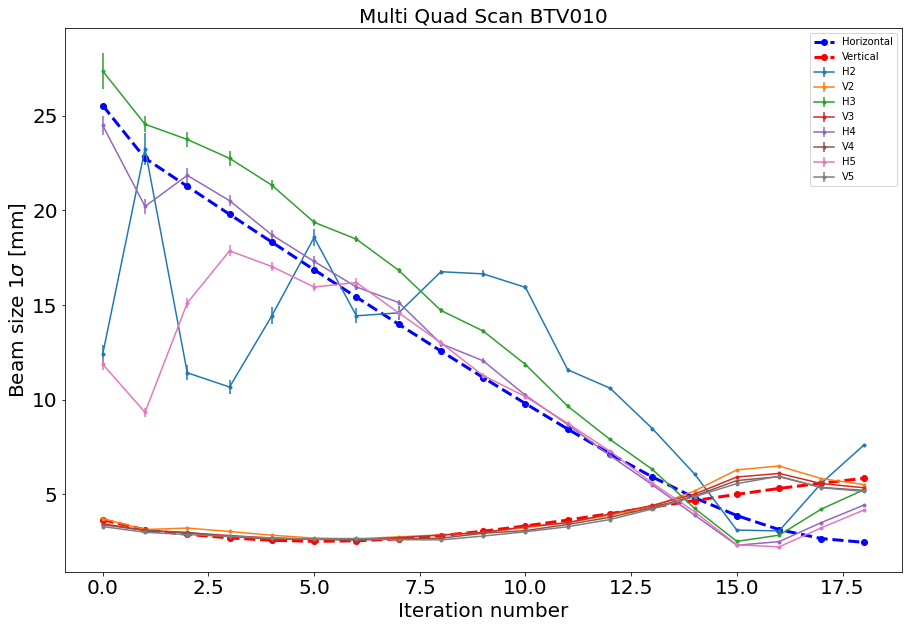

In [50]:
fig, ax = plt.subplots(figsize=(15,10))

H_sigma_list = []
V_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")

    H_sigma_list.append(H_sigma_list_i)
    V_sigma_list.append(V_sigma_list_i)
    
ax.plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "Horizontal")
ax.plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "Vertical")


ax.legend()
ax.set_xlabel("Iteration number", fontsize=20)
ax.set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.savefig("fig/madx_"+str(filename)+".png", facecolor='white', transparent=False,
                    bbox_inches='tight', dpi=150);
ax.set_title("Multi Quad Scan BTV010", fontsize = 20)